In [1]:
# EMC2 WP 2 Appendix A 1. : Test of CSR (SUBSET)
# 
# This script analyzes the spatial distribution of two observed point patterns and compares it to a random distribution of points to determine if 
# there is clustering, dispersion, or randomness in the point pattern. In the context of the EMC2 project, this script is used to compare the 
# distribution of all buildings and buildings with NA values for the number of dwellings to a random distribution of points. The objective is to 
# assess if NA values are more or less randomly distributed than the observed data.

# Author : Perez Joan
# Generic input data : A single polygon GeoDataFrame object (from which a subset is extracted)
# emc2 input data : output from emc2 WP 2 Processing 0.1 (SUBSET)

import geopandas as gpd
import numpy as np
from scipy.spatial import distance
from shapely.geometry import MultiPoint
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from scipy.spatial.distance import cdist

# Specify the location of output from 1.1
gpkg = "C:\\Users\\...\\WP2_DPC_06_0.1_Subset.gpkg"

# Read the data
polygon = gpd.read_file(gpkg, layer="building")
polygon_na = polygon[polygon['nombre_de_logements'].isna()]

Area difference between convex hull and bounding box (ratio): 0.4123221321899625


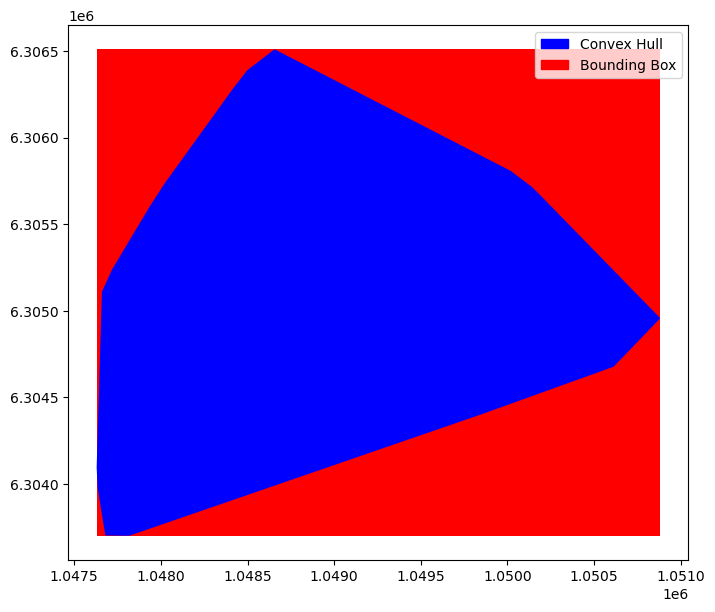

In [2]:
# 1. Bounding box / convex hull difference for ob

# Calculate observed points as centroids of the polygons and extract coordinates
observed_points = polygon.centroid
points_geom = gpd.GeoDataFrame(geometry=observed_points)
coordinates = np.array([[points.coords[0][0], points.coords[0][1]] for points in points_geom.geometry])

# Create convex hull
hull = MultiPoint(observed_points).convex_hull
hull_gdf = gpd.GeoDataFrame(geometry=[hull])

# Define function to create a bounding box polygon
def create_bounding_box_polygon(points):
    min_x, min_y, max_x, max_y = points.total_bounds  # Calculate the minimum and maximum coordinates
    corners = [(min_x, min_y), (max_x, min_y), (max_x, max_y), (min_x, max_y)] # Define the corners of the bounding box polygon
    bounding_box_polygon = Polygon(corners) # Create the bounding box polygon
    bounding_box_gdf = gpd.GeoDataFrame(geometry=[bounding_box_polygon])  # Create a GeoDataFrame containing the bounding box polygon
    return bounding_box_gdf
bounding_box_polygon = create_bounding_box_polygon(observed_points) # Create bounding box polygon

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the bounding box and convex hull polygons
bounding_box_plot = bounding_box_polygon.plot(ax=ax, color='red')
hull_plot = hull_gdf.plot(ax=ax, color='blue')

# Create legend using proxy artists
legend_handles = [
    Patch(color='blue', label='Convex Hull'),
    Patch(color='red', label='Bounding Box')
]
ax.legend(handles=legend_handles)

# Calculate the area difference between convex hull and bounding box
area_convex_hull = hull_gdf.area.values[0]
area_bounding_box = bounding_box_polygon.area.values[0]
percentage_difference = abs((area_convex_hull - area_bounding_box) / area_bounding_box)
print("Area difference between convex hull and bounding box (ratio):", percentage_difference)

In [3]:
# 2. Generate and extract coordinates for random data
# Calculate the bounding box of observed points
min_x, min_y, max_x, max_y = observed_points.total_bounds
np.random.seed(123)  # for reproducibility

# Generate random points within the bounding box (number of point generated is increased based on the difference between the convex hull and 
# the bounding box surface
random_points_x = np.random.uniform(min_x, max_x, round(len(observed_points) * (1 + percentage_difference)))
random_points_y = np.random.uniform(min_y, max_y, round(len(observed_points) * (1 + percentage_difference)))
random_points_geom = gpd.GeoDataFrame(geometry=gpd.points_from_xy(random_points_x, random_points_y))

# Extract coordinates of the random points
coordinates_random = np.array([[point.x, point.y] for point in random_points_geom.geometry])

In [4]:
# 3. Funcion to calculate nearest neighbor distances and standar deviation on nearest neighbor distances
# Function to calculate nearest neighbor distances
def nearest_neighbor_distances(points):
    # Calculate pairwise distances between points
    distances = cdist(points, points)
    np.fill_diagonal(distances, np.inf)  # Exclude distance to itself
    # Calculate nearest neighbor distances
    nearest_distances = np.min(distances, axis=1)
    return nearest_distances

# SD on the nearest neighbor distances
def nearest_neighbor_sd(points):
    # Calculate nearest neighbor distances
    nearest_distances = nearest_neighbor_distances(points)
    # Calculate standard deviation of nearest neighbor distances
    sd = np.std(nearest_distances)
    return sd

The observed point pattern (mean: 12.87) is significantly clustered compared to the random pattern (mean: 25.32).


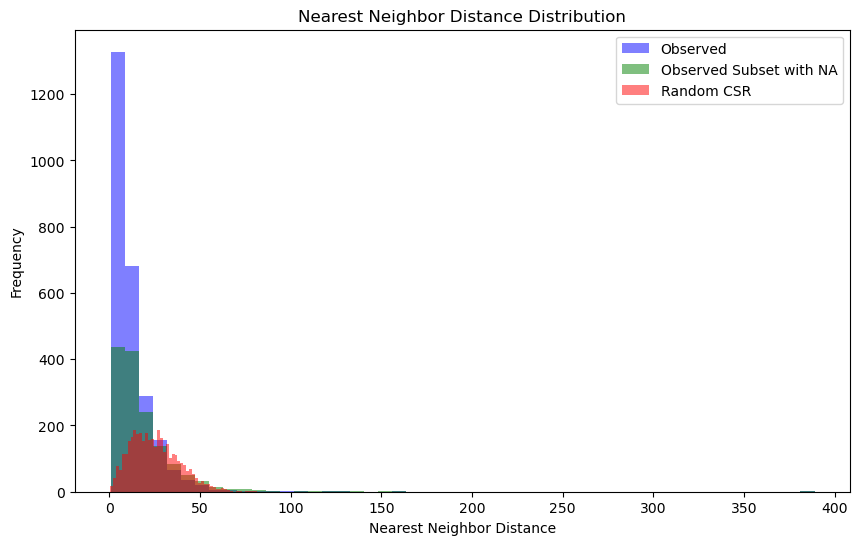

The subset values are more dispersed.
Mean nearest neighbor distance for observed points: 12.87
Mean nearest neighbor distance for observed subset with NA values: 18.78


In [5]:
# 4. Compare mean nearest neighbor distances observed vs. observed subset vs. random
mean_observed_nn = np.mean(nearest_neighbor_distances(coordinates))
mean_random_nn = np.mean(nearest_neighbor_distances(coordinates_random))
std_random_nn = np.std(nearest_neighbor_distances(coordinates_random))
# Compare if the subset with NA values is more or less randomly distributed
observed_points_na = polygon_na.centroid
points_geom_na = gpd.GeoDataFrame(geometry=observed_points_na)
coordinates_na = np.array([[points.coords[0][0], points.coords[0][1]] for points in points_geom_na.geometry])
mean_observed_na_nn = np.mean(nearest_neighbor_distances(coordinates_na))

observed_nn_distances = nearest_neighbor_distances(coordinates)
observed_subset_nn_distances = nearest_neighbor_distances(coordinates_na)
random_nn_distances = nearest_neighbor_distances(coordinates_random)
mean_observed_na_nn = np.mean(nearest_neighbor_distances(coordinates_na))

# Calculate threshold of within CSR (-1/2 +1/2 sd)
lower_bound = mean_random_nn - 0.5 * std_random_nn
upper_bound = mean_random_nn + 0.5 * std_random_nn

# Assess clustering or dispersion
if mean_observed_nn < lower_bound:
    print(f"The observed point pattern (mean: {mean_observed_nn:.2f}) is significantly clustered compared to the random pattern (mean: {mean_random_nn:.2f}).")
elif mean_observed_nn > upper_bound:
    print(f"The observed point pattern (mean: {mean_observed_nn:.2f}) is significantly dispersed compared to the random pattern (mean: {mean_random_nn:.2f}).")
else:
    print(f"The observed point pattern (mean: {mean_observed_nn:.2f}) is consistent with CSR (mean random: {mean_random_nn:.2f}).")

# Plot histograms of nearest neighbor distances
plt.figure(figsize=(10, 6))
plt.hist(observed_nn_distances, bins=50, color='blue', alpha=0.5, label='Observed')
plt.hist(nearest_neighbor_distances(coordinates_na), bins=50, color='green', alpha=0.5, label='Observed Subset with NA')
plt.hist(random_nn_distances, bins=50, color='red', alpha=0.5, label='Random CSR')
plt.xlabel('Nearest Neighbor Distance')
plt.ylabel('Frequency')
plt.title('Nearest Neighbor Distance Distribution')
plt.legend()
plt.show()

# Compare mean nearest neighbor distances
if mean_observed_nn > mean_observed_na_nn:
    print("The subset values are more clustered.")
    print(f"Mean nearest neighbor distance for observed points: {mean_observed_nn:.2f}")
    print(f"Mean nearest neighbor distance for observed subset with NA values: {mean_observed_na_nn:.2f}")
else:
    print("The subset values are more dispersed.")
    print(f"Mean nearest neighbor distance for observed points: {mean_observed_nn:.2f}")
    print(f"Mean nearest neighbor distance for observed subset with NA values: {mean_observed_na_nn:.2f}")